# Modelagem da pergunta 

## Qual é a tendência para o futuro em relação à criminalidade em Curitiba? 

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
%matplotlib inline

# Exporting cvs file for the DataSUS dataset
df = pd.read_csv('../02 - Analise exploratoria/Datasets/sigesguarda_ocorrencias_por_mes.csv', sep=',', encoding='latin-1')
df["DATA"] = pd.to_datetime(df["DATA"])
df.head(10)

,DATA,OCORRENCIAS
0,2009-01-01,2227
1,2009-02-01,1971
2,2009-03-01,2133
3,2009-04-01,2005
4,2009-05-01,1974
5,2009-06-01,1765
6,2009-07-01,1983
7,2009-08-01,2016
8,2009-09-01,2141
9,2009-10-01,2173


In [140]:
pop = pd.read_csv('../02 - Analise exploratoria/Datasets/populacao_estimada_curitiba.csv', sep=',', encoding='latin-1')
pop = pop.rename(columns = {'ano':'ANO', 'populacao_estimada':'POPULACAO'})
df1 = pd.read_csv('../02 - Analise exploratoria/Datasets/sigesguarda_ocorrencias_ano.csv', sep=',', encoding='latin-1')
df1["POPULACAO"] = pop["POPULACAO"]
df1 = df1.rename(columns = {'Unnamed: 0':'DATA'})
df1

,DATA,OCORRENCIAS,POPULACAO
0,2009,24903,1851215
1,2010,22531,1851215
2,2011,21484,1764541
3,2012,19776,1776761
4,2013,24470,1848946
5,2014,25303,1864416
6,2015,25566,1879355
7,2016,21469,1893997
8,2017,22137,1908359
9,2018,24153,1917185


<AxesSubplot:xlabel='DATA'>

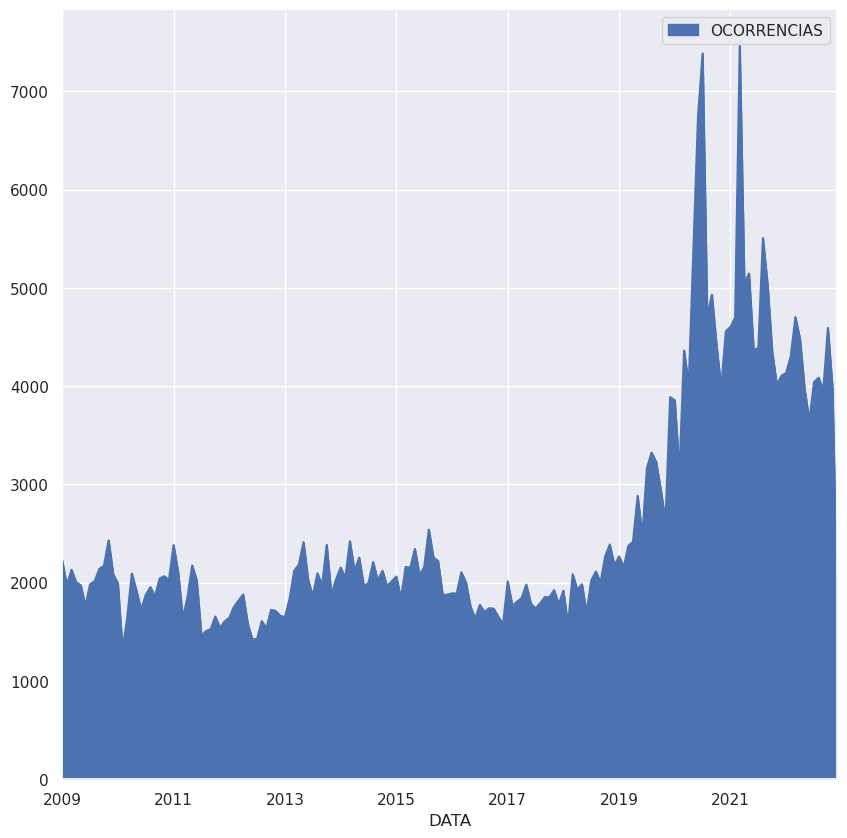

In [141]:
df.plot(x="DATA", y="OCORRENCIAS", kind="area")

## Criação do modelo

#### Modelo de regressão linear

Para utilizar as funções de regressão o formato datetime64 não é compatível, portanto os valores de data foram expressos por "timestamp"

In [142]:
df["ts"] = df["DATA"].values.astype(np.int64) // 10 ** 9
df.tail(10)

,DATA,OCORRENCIAS,ts
158,2022-03-01,4703,1646092800
159,2022-04-01,4476,1648771200
160,2022-05-01,3965,1651363200
161,2022-06-01,3649,1654041600
162,2022-07-01,4041,1656633600
163,2022-08-01,4087,1659312000
164,2022-09-01,3960,1661990400
165,2022-10-01,4594,1664582400
166,2022-11-01,3980,1667260800
167,2022-12-01,1711,1669852800


In [143]:
model = smf.ols("OCORRENCIAS ~ ts", data=df)
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            OCORRENCIAS   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     141.1
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           6.09e-24
Time:                        21:48:17   Log-Likelihood:                -1376.9
No. Observations:                 168   AIC:                             2758.
Df Residuals:                     166   BIC:                             2764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6640.3466    777.222     -8.544      0.000   -8174.861   -5105.832
ts          6.341e-06   5.34e-07     11.878      0.000    5.29e-06    7.39e-06
==============================================================================
Omnibus:                       54.487   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.767
Skew:                           1.286   Prob(JB):                     2.74e-36
Kurtosis:                       7.096   Cond. No.                     1.66e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

O modelo inicial apresentou um $𝑟^2=0.459$, explicando perto de 50% da variância. Levando em consideração a natureza da hipótese sendo discutida, vamos progredir utilizando apenas o tempo como variável independente mesmo.

<AxesSubplot:>

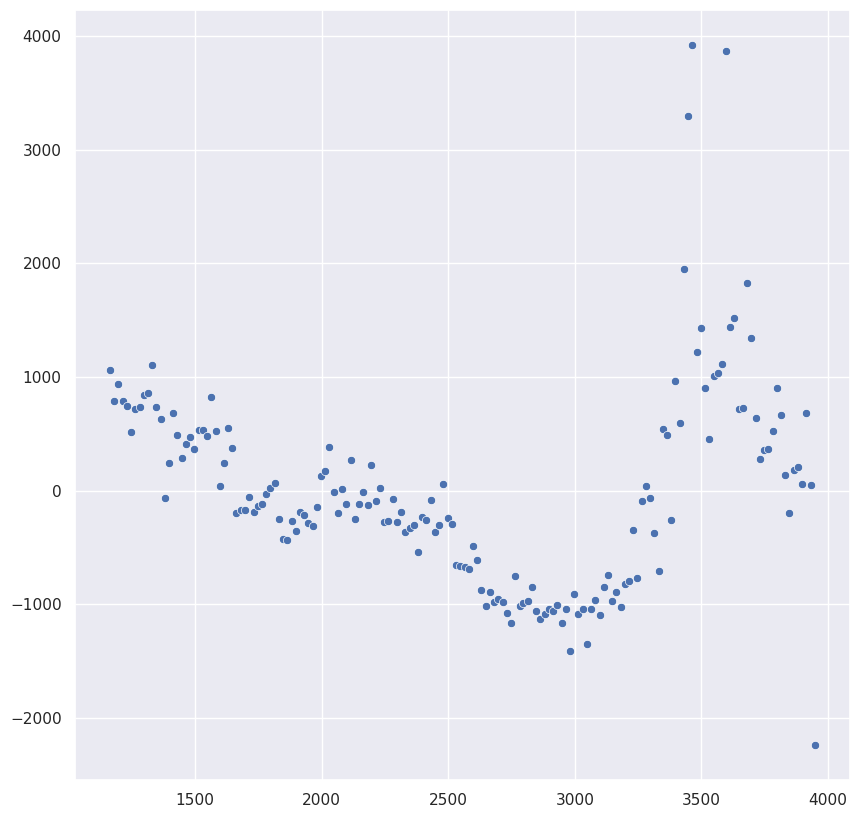

In [144]:
pred_val = response.fittedvalues.copy()
true_val = df['OCORRENCIAS'].values.copy()
residual = true_val - pred_val

sns.scatterplot(x = pred_val, y = residual)

<AxesSubplot:xlabel='DATA', ylabel='OCORRENCIAS'>

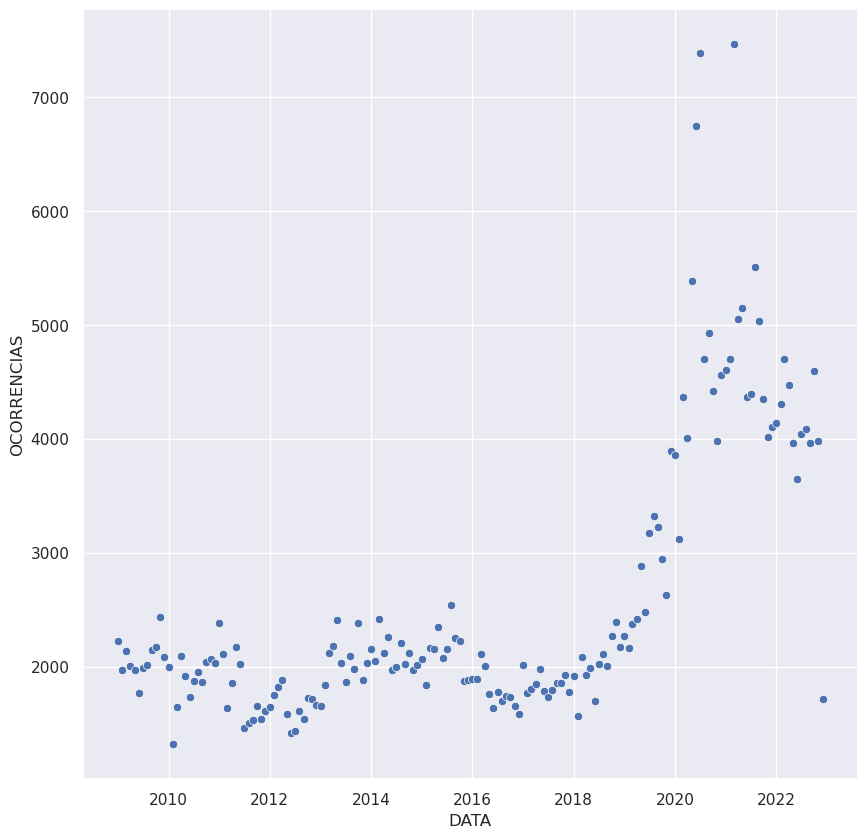

In [145]:
sns.scatterplot(x = df["DATA"], y = df["OCORRENCIAS"])

Os resultados obtidos não representam nenuhm resultado útil, o motivo disto aparenta ser um erro na escolha do modelo. Portanto os próximos testes vão realizar uma Análise de Série Temporal

#### Modelo de Análise de Série Temporal (Todas Ocorrências em um período mensal)

In [146]:
df_ast = df
df_ast = df_ast.set_index('DATA')
df_ast.tail(10)

,OCORRENCIAS,ts
DATA,,
2022-03-01,4703,1646092800
2022-04-01,4476,1648771200
2022-05-01,3965,1651363200
2022-06-01,3649,1654041600
2022-07-01,4041,1656633600
2022-08-01,4087,1659312000
2022-09-01,3960,1661990400
2022-10-01,4594,1664582400
2022-11-01,3980,1667260800


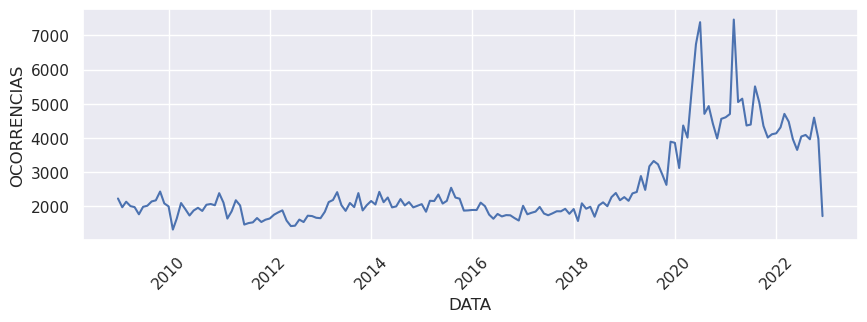

In [147]:
plt.rcParams.update({'figure.figsize': (10,3)})
sns.lineplot(x="DATA", y="OCORRENCIAS",  data=df_ast)

plt.xticks(rotation=45)
plt.show()

Para verificar as tendências de sazonalidade, aplicamos autocorrelação na séria temporal, usamos um valor de 36 deslocamentos para equivaler a 4 anos de deslocamento.

/home/heitordt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


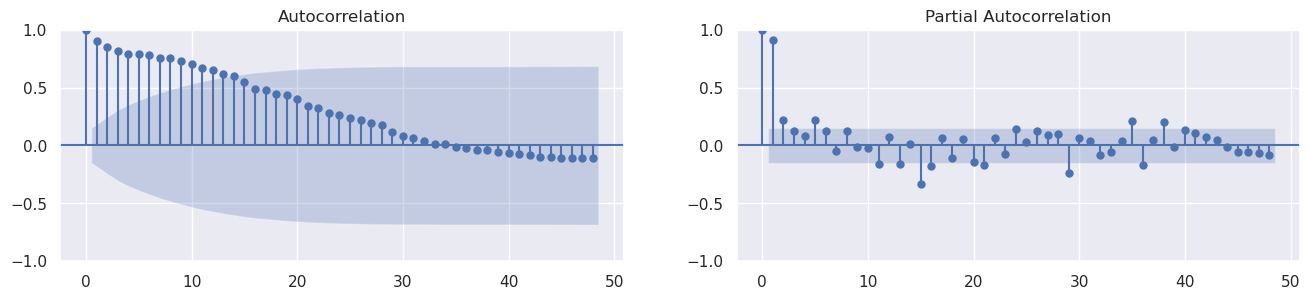

In [148]:
# source: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_ast.OCORRENCIAS.tolist(), lags=48, ax=axes[0])
plot_pacf(df_ast.OCORRENCIAS.tolist(), lags=48, ax=axes[1])

plt.show()

## Hipótese: Com o aumento da população há aumento de ocorrências

In [149]:
model_2 = smf.ols("OCORRENCIAS ~ DATA + POPULACAO", data=df1)
response_2 = model_2.fit()
response_2.summary()

/home/heitordt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            OCORRENCIAS   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     7.581
Date:                Thu, 29 Jun 2023   Prob (F-statistic):            0.00852
Time:                        21:48:19   Log-Likelihood:                -146.51
No. Observations:                  14   AIC:                             299.0
Df Residuals:                      11   BIC:                             300.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.106e+06    2.5e+06     -1.244      0.239    -8.6e+06    2.39e+06
DATA        1489.8147   1310.281      1.137      0.280   -1394.094    4373.724
POPULACAO      0.0710      0.088      0.809      0.436      -0.122       0.264
==============================================================================
Omnibus:                        0.204   Durbin-Watson:                   0.753
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.384
Skew:                           0.175   Prob(JB):                        0.825
Kurtosis:                       2.268   Cond. No.                     1.84e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ao custo de um número bem inferior de observações realizando a regressão com os dados anuais somados com a população estimada conseguimos alcançar um $r^2 = 0.580$

#### Modelo de Análise de Série Temporal (Ocorrências violentas em um período mensal)

In [150]:
df_crimes_especificos_por_ano_mes = pd.read_csv('../02 - Analise exploratoria/Datasets/sisgegarda_crimes_violentos_por_ano_mes.csv', sep=',', encoding='latin-1')
df_crimes_especificos_por_ano_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ANO_MES      168 non-null    object
 1   OCORRENCIAS  168 non-null    int64 
 2   ANO          168 non-null    int64 
 3   MES          168 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.4+ KB


In [151]:
df_crimes_especificos_por_ano_mes['ANO_MES'] = pd.to_datetime(df_crimes_especificos_por_ano_mes['ANO_MES'])
df_crimes_especificos_por_ano_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ANO_MES      168 non-null    datetime64[ns]
 1   OCORRENCIAS  168 non-null    int64         
 2   ANO          168 non-null    int64         
 3   MES          168 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.4 KB


<AxesSubplot:xlabel='ANO_MES'>

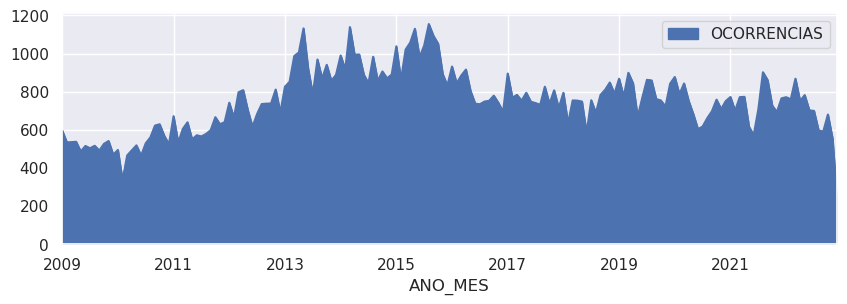

In [152]:
df_crimes_especificos_por_ano_mes.plot(x="ANO_MES", y="OCORRENCIAS", kind="area")

In [153]:
df_crimes_especificos_por_ano_mes = df_crimes_especificos_por_ano_mes.set_index('ANO_MES')
df_crimes_especificos_por_ano_mes.head(10)

,OCORRENCIAS,ANO,MES
ANO_MES,,,
2009-01-01,596,2009,1
2009-02-01,534,2009,2
2009-03-01,535,2009,3
2009-04-01,537,2009,4
2009-05-01,486,2009,5
2009-06-01,515,2009,6
2009-07-01,503,2009,7
2009-08-01,516,2009,8
2009-09-01,491,2009,9


In [123]:
df_crimes_especificos_pop = df_crimes_especificos_por_ano_mes


df_crimes_especificos_pop = df_crimes_especificos_pop.reset_index()
df_crimes_especificos_pop = pd.merge(df_crimes_especificos_pop,df1[['DATA','POPULACAO']],left_on='ANO', right_on='DATA', how='left')
df_crimes_especificos_pop = df_crimes_especificos_pop.set_index('ANO_MES')
df_crimes_especificos_pop.drop(axis=1, columns='DATA', inplace=True)
df_crimes_especificos_pop['OCCOR10000'] = df_crimes_especificos_pop['OCORRENCIAS']/df_crimes_especificos_pop['POPULACAO']*10000

#df_crimes_especificos_pop.plot(x="ANO_MES", y="OCORR10000", kind='line')

<AxesSubplot:xlabel='ANO_MES', ylabel='teste'>

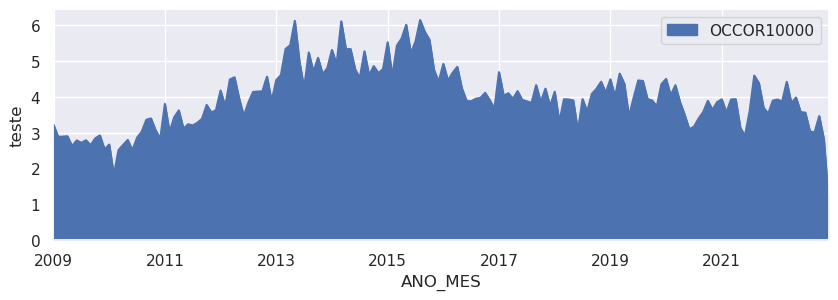

In [155]:
df_crimes_especificos_pop.plot(x="ANO_MES", y="OCCOR10000",ylabel='teste', kind="area")

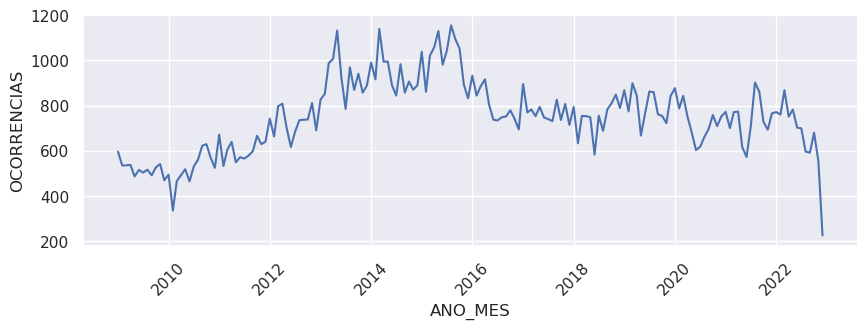

In [16]:
plt.rcParams.update({'figure.figsize': (10,3)})
sns.lineplot(x="ANO_MES", y="OCORRENCIAS",  data=df_crimes_especificos_por_ano_mes)

plt.xticks(rotation=45)
plt.show()

/home/heitordt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


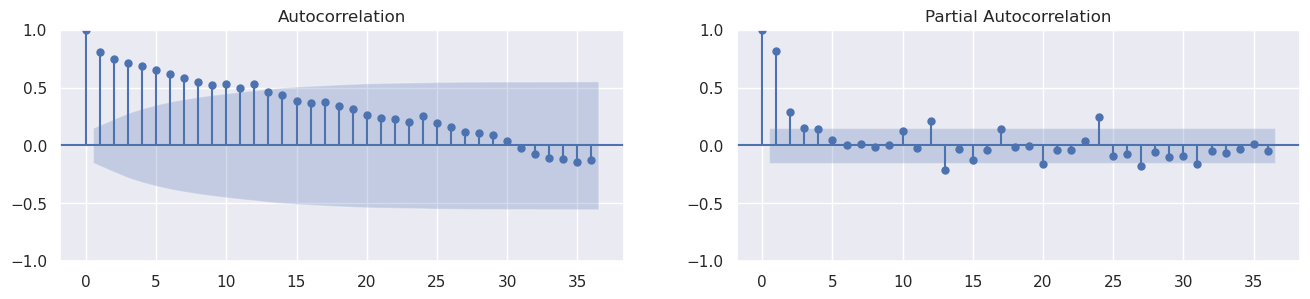

In [17]:
# source: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_crimes_especificos_por_ano_mes.OCORRENCIAS.tolist(), lags=36, ax=axes[0])
plot_pacf(df_crimes_especificos_por_ano_mes.OCORRENCIAS.tolist(), lags=36, ax=axes[1])

plt.show()

Com uma aparente sazonalidade anual (12 meses) aplicando uma média móvel com a janela de 12 meses.

In [18]:
df_crimes_especificos_por_ano_mes['OCORRENCIAS_MEDIA_MOVEL'] = df_crimes_especificos_por_ano_mes['OCORRENCIAS'].rolling(12, center=True).mean()

df_crimes_especificos_por_ano_mes.head(10)

,OCORRENCIAS,ANO,MES,OCORRENCIAS_MEDIA_MOVEL
ANO_MES,,,,
2009-01-01,596,2009,1,NaN
2009-02-01,534,2009,2,NaN
2009-03-01,535,2009,3,NaN
2009-04-01,537,2009,4,NaN
2009-05-01,486,2009,5,NaN
2009-06-01,515,2009,6,NaN
2009-07-01,503,2009,7,520.750000
2009-08-01,516,2009,8,512.250000
2009-09-01,491,2009,9,495.666667


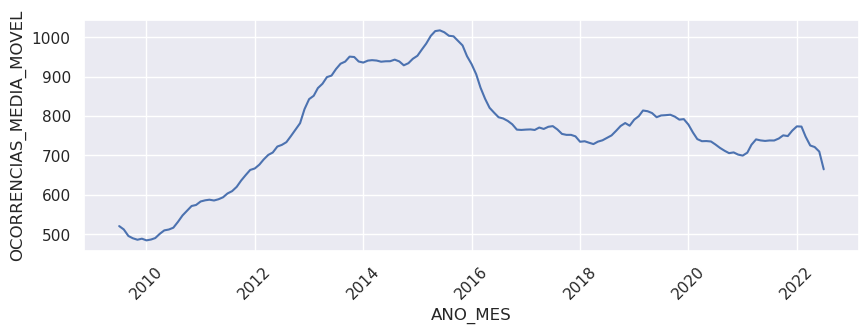

In [19]:
sns.lineplot(x="ANO_MES", y="OCORRENCIAS_MEDIA_MOVEL",  data=df_crimes_especificos_por_ano_mes)
plt.xticks(rotation=45)
plt.show()

Aplicando uma nova média móvel para suavizar a séria (uso de weighted moving average)

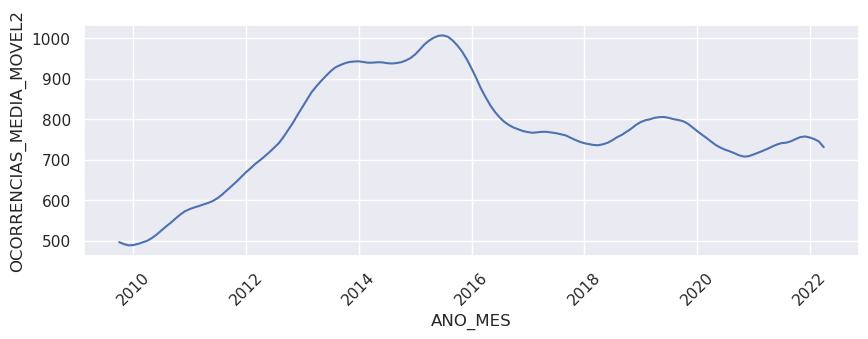

In [20]:
df_crimes_especificos_por_ano_mes['OCORRENCIAS_MEDIA_MOVEL2'] = df_crimes_especificos_por_ano_mes['OCORRENCIAS_MEDIA_MOVEL'].rolling(7, center=True).mean()

df_crimes_especificos_por_ano_mes = df_crimes_especificos_por_ano_mes.dropna(how='any')

sns.lineplot(x="ANO_MES", y="OCORRENCIAS_MEDIA_MOVEL2",  data=df_crimes_especificos_por_ano_mes)
plt.xticks(rotation=45)
plt.show()

Usando a média móvel com peso (7xf(12)) como a tendência de ocorrências.

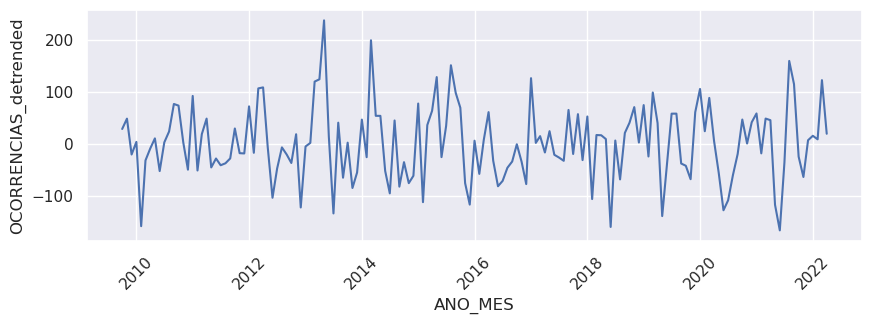

In [21]:
df_crimes_especificos_por_ano_mes['OCORRENCIAS_trend'] = df_crimes_especificos_por_ano_mes['OCORRENCIAS_MEDIA_MOVEL2']

df_crimes_especificos_por_ano_mes['OCORRENCIAS_detrended'] = df_crimes_especificos_por_ano_mes['OCORRENCIAS'] - df_crimes_especificos_por_ano_mes['OCORRENCIAS_trend']

sns.lineplot(x="ANO_MES", y="OCORRENCIAS_detrended",  data=df_crimes_especificos_por_ano_mes)
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='MES', ylabel='OCORRENCIAS'>

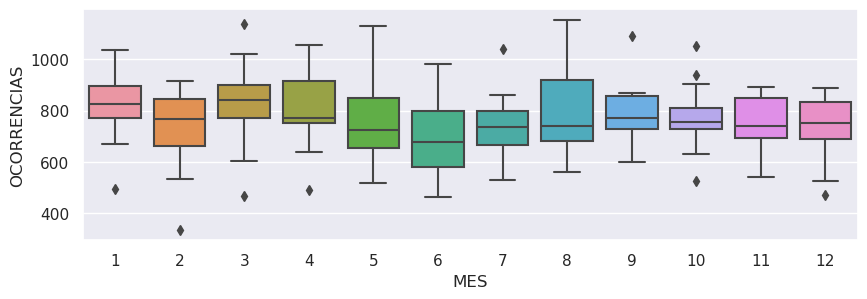

In [22]:
sns.boxplot(x='MES', y='OCORRENCIAS', data=df_crimes_especificos_por_ano_mes)

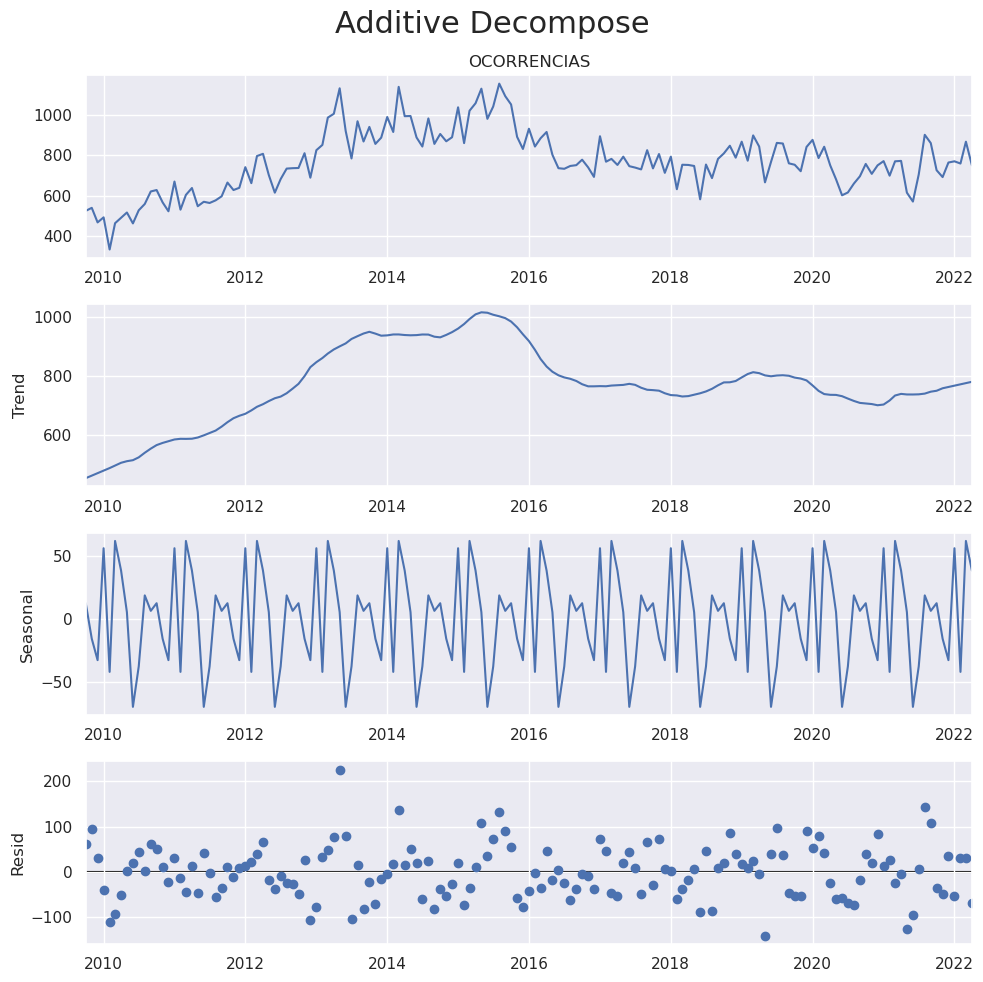

In [23]:
df_crimes_especificos_por_ano_mes = df_crimes_especificos_por_ano_mes.dropna(how='any')

# Additive Decomposition
result_add = seasonal_decompose(df_crimes_especificos_por_ano_mes['OCORRENCIAS'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})

result_add.plot().suptitle('Additive Decompose', fontsize=22)

plt.tight_layout()
plt.show()

In [27]:
#Run ADF test
adf_result = adfuller(df_crimes_especificos_por_ano_mes['OCORRENCIAS'], autolag='AIC')
print('p-val do teste ADF sobre OCORRÊNCIAS:', adf_result[1])

adf_result = adfuller(df_crimes_especificos_por_ano_mes['OCORRENCIAS_detrended'], autolag='AIC')
print('p-val do teste ADF sobre OCORRÊNCIAS_detrended:', adf_result[1])

p-val do teste ADF sobre OCORRÊNCIAS: 0.26309371648200897
p-val do teste ADF sobre OCORRÊNCIAS_detrended: 8.544612443404115e-05


### Análise refeita com os dados sem tendência aplicada

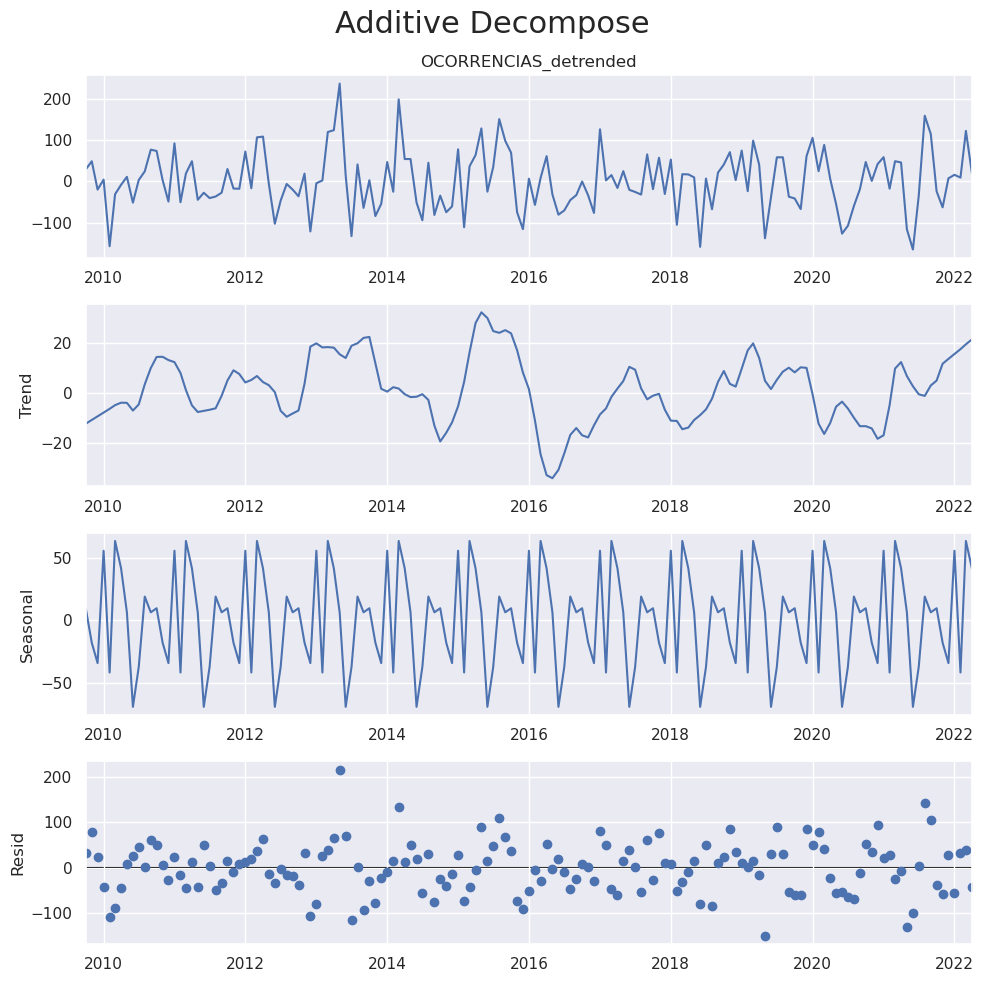

In [26]:
df_crimes_especificos_por_ano_mes = df_crimes_especificos_por_ano_mes.dropna(how='any')

# Additive Decomposition
result_add = seasonal_decompose(df_crimes_especificos_por_ano_mes['OCORRENCIAS_detrended'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})

result_add.plot().suptitle('Additive Decompose', fontsize=22)

plt.tight_layout()
plt.show()